## Backpropagation in Simple NN

Task: Modify provided code "Three_layer_neural_network.py" to build a 3-layer neural network and train with backpropagation.

In [4]:
%load_ext autoreload
%autoreload 2
import numpy as np
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt
% matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


### Dataset 

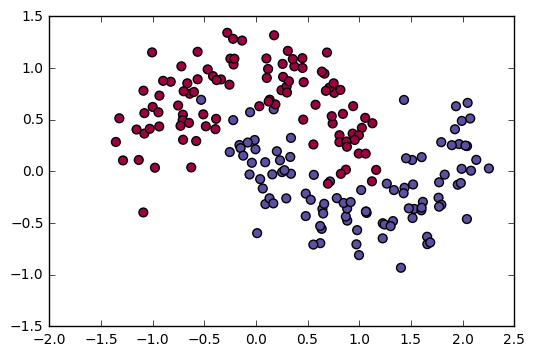

In [5]:
 # generate and visualize Make-Moons dataset
def generate_data():
    '''
    generate data
    :return: X: input data, y: given labels
    '''
    np.random.seed(0)
    X, y = datasets.make_moons(200, noise=0.20)
    return X, y

X, y = generate_data()
plt.scatter(X[:, 0], X[:, 1], s=40, c=y, cmap=plt.cm.Spectral)

The above data is the Make-moon data from sklearn library, which contains two color-coded classes of data forming half-moon shape each.

### Activation function

Tanh, Sigmoid and ReLU are popular activation functions used in neural network. Here, we will practice implementing them and their derivatives.

Definiatio of different activaiton function are as follows:
1. Tanh:
$ tanh(z) = \frac {e^{z} - e^{-z}}{e^{z} + e^{-z}}$
2. Sigmoid:
$ sigmoid(z) = \frac {1}{1+e^{-z}}$
3. ReLu:
$ ReLu(z) = max([z,0]) $

In [6]:
def actFun(z, type):
    '''
    actFun computes the activation functions
    :param z: net input
    :param type: Tanh, Sigmoid, or ReLU
    :return: activations
    '''
    if type == 'Tanh':
        e_z = np.exp(z)
        e_z2 = np.exp(-z)
        output  = (e_z - e_z2)/(e_z + e_z2)
        
    elif type == 'Sigmoid':
        output = 1/(1+np.exp(-z))
        
    elif type == 'ReLU':
        output = (z >= 0) * z
        
    else:
        print('Wrong activation function type')

    return output

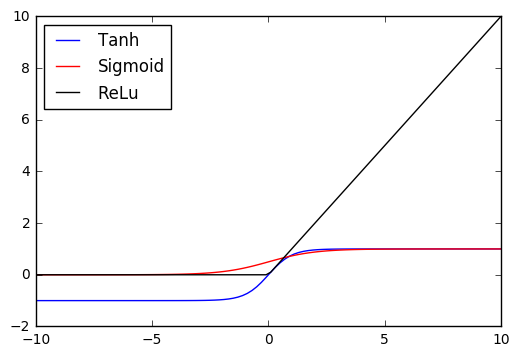

In [7]:
z = np.linspace(-10, 10 ,100)

output_Tanh = actFun(z,'Tanh')
output_Sigmoid = actFun(z,'Sigmoid')
output_ReLU = actFun(z, 'ReLU')
plt.plot(z, output_Tanh, label = 'Tanh')
plt.plot(z, output_Sigmoid, 'r', label = 'Sigmoid')
plt.plot(z, output_ReLU, 'k', label = 'ReLu')
plt.legend(loc = 'upper left')

### Build the neural network


Now we are going to build a three-layer-neural-network, one input layer, one hidden layer and one output layer.

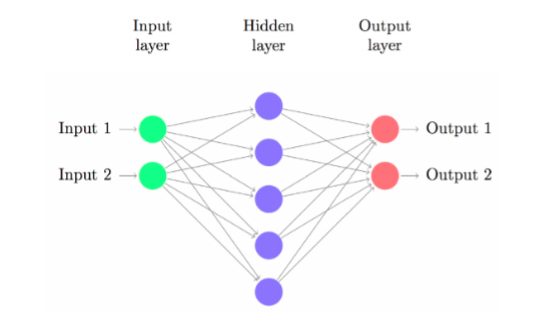

In [8]:
from IPython.display import Image
Image(filename='Three_laye neural_network.png')

Mathematically, the network could be defined as follows:

$ z_{1} = W_{1}x + b_{1}$

$ a_{1} = actFun(z_{1}) $

$ z_{2} = W_{2}a_{1} + b{2}$

$ a_{2} = \hat y = softmax(z_{2}) $

Softmax is one way to map any output activity into a normalized probability index voting for one of the two classes.
Importantly, activation function normally only applies to input and hidden layer units, but not output units.

### Forward Pass - Inference

After obtaining the distribution of estimated output $\hat y _{n, i}$, we could evaluate the performance of the estimation by calculating cross-entropy, whis is summed over all samples and across all classes. Detailed explanation could be found http://colah.github.io/posts/2015-09-Visual-Information/. Entropy represents the minimum amount of bits that need to use to communicate a certain distribution, i.e., the optimal coding strategy. It could be written as: 

$ H(x) = \sum_{x} p(x) log \frac{1}{p(x)}$

Cross entropy indicate the amounts of bits that need to code one distrbution with the coding strategy that best represent for another distribution.

$ H_{p}(q) = \sum_{x}q(x) log \frac{1}{p(x)}$

In our case, we consider the coding strategy we are using is the true distribution $y_{n,i}$ and we are coding for the estimated output: $\hat y_{n,i}$

$ L(y, \hat y) = - \frac{1}{N} \sum_{n\in N}\sum_{i\in C} y_{n, i}log(\hat y_{n,i})$

In our case, since the output has two dimensions and y takes 0 or 1, we could rewrite the loss function as:

$ L(y, \hat y) = - \frac{1}{N} \sum_{n\in N} [y_{n, i}log(\hat y_{n,i}) + (1-y_{n, i})log(1 - \hat y_{n, i})]$

In [9]:
# Implement the initialization part

nn_input_dim = 2
nn_hidden_dim = 10
nn_output_dim = 2
reg_lambda=0.01
seed=0

# initialize the weights and biases in the network
np.random.seed(seed)
W1 = np.random.randn(nn_input_dim, nn_hidden_dim) / np.sqrt(nn_input_dim)
b1 = np.zeros((1, nn_hidden_dim))
W2 = np.random.randn(nn_hidden_dim, nn_output_dim) / np.sqrt(nn_hidden_dim)
b2 = np.zeros((1, nn_output_dim))

In [10]:
# Estimate the probability of the input belonging to a certain category

def feedforward(X, actFun_type):
    '''
    feedforward builds a 3-layer neural network and computes the two probabilities,
    one for class 0 and one for class 1
    :param X: input data
    :param actFun: activation function
    :return:
    '''
    z1 = np.dot(X, W1) + b1
    a1 = actFun(z1,actFun_type)
    z2 = np.dot(a1, W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    
    return probs, a1, z1

actFun_type='Tanh'
y_hat = feedforward(X, actFun_type)

In [11]:
# Convert true output to samplesize by 2 matrices:
y_true = np.zeros([len(X),2])
for i in range(len(y_true)):
    y_true[i, y[i]] = 1

In [12]:
# Caculate the loss
def calculate_loss(X, y):
    '''
    calculate_loss computes the loss for prediction
    :param X: input data
    :param y: given labels
    :return: the loss for prediction
    '''
    num_examples = len(X)
    probs = feedforward(X, lambda x: self.actFun(x, type=self.actFun_type))
    # Calculating the loss
    data_loss = np.sum(np.sum(np.multiply(y_true, np.log(y_hat))))
    # Add regulatization term to loss (optional)
    data_loss += self.reg_lambda / 2 * (np.sum(np.square(self.W1)) + np.sum(np.square(self.W2)))
    return (1. / num_examples) * data_loss

### Backward Pass - Backpropagation

To make use of the loss function, we need to convert it to change of weights and biases of the network. To do that, we need to derive the relationship between defined loss function and each parameter

$ \frac {\partial W_{2}}{\partial t} = -\frac {\partial L}{\partial W_{2}} = -\frac{1}{N} \sum_{n\in N}[\hat y_{n,i}-y]a_{1}$ 

$ \frac {\partial b_{2}}{\partial t} =  -\frac {\partial L}{\partial b_{2}} = -\frac{1}{N} \sum_{n\in N}[\hat y_{n,i}-y]$

$ \frac {\partial W_{1}}{\partial t} =  -\frac {\partial L}{\partial W_{1}} = -\frac{1}{N} \sum_{n\in N}[\hat y_{n,i}-y]w_{2}\sigma'(z_{1})x$

$  \frac {\partial b_{1}}{\partial t} = -\frac {\partial L}{\partial b_{1}} = -\frac{1}{N} \sum_{n\in N}[\hat y_{n,i}-y]w_{2}\sigma'(z_{1}) $

In [13]:
def backprop(X, y,actFun_type):
    """
   backprop implements backpropagation to compute the gradients used to update the parameters in the backward step
   :param X: input data
   :param y: given labels
   :return: dL/dW1, dL/b1, dL/dW2, dL/db2
   """
    # IMPLEMENT YOUR BACKPROP HERE
    num_examples = len(X)
    delta3, a1, z1= feedforward(X, actFun_type)
    delta3[range(num_examples), y] -= 1
    
    dW2 = np.dot(a1.T, delta3)
    db2 = np.mean(delta3, axis = 0)
    dW1 = np.dot(np.multiply(np.dot(W2, delta3.T), dsigmoid(z1).T), X)
    # dW1 = np.multiply(delta3 ,np.dot(W2, np.dot(dsigmoid(z1).T,X)))
    db1 = np.mean(np.multiply(np.dot(W2, delta3.T), dsigmoid(z1).T), axis = 0)
    
    return
# dW1, dW2, db1, db2

def sigmoid(z):
    return 1/(1+np.exp(-1 * z))

def dsigmoid(z):
    return sigmoid(z) * (1 - sigmoid(z))

test = backprop(X, y, 'Sigmoid')

Test the modified py function

In [15]:
%load_ext autoreload
%autoreload 2
import three_layer_neural_network_SL

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
three_layer_neural_network_SL.main('ReLU')

NameError: name 'three_layer_neural_network' is not defined

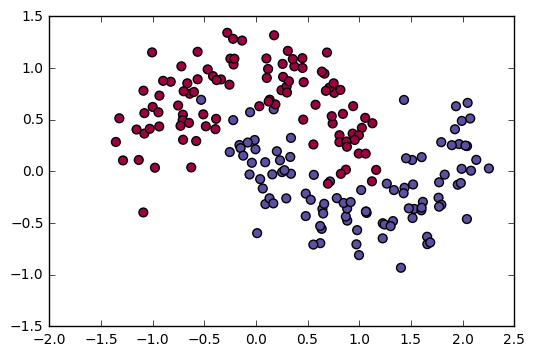

Loss after iteration 0: -0.435126
Loss after iteration 1000: -0.183755
Loss after iteration 2000: -0.135851
Loss after iteration 3000: -0.108091
Loss after iteration 4000: -0.091759
Loss after iteration 5000: -0.095994
Loss after iteration 6000: -0.090818
Loss after iteration 7000: -0.086921
Loss after iteration 8000: -0.083654
Loss after iteration 9000: -0.080776
Loss after iteration 10000: -0.078235
Loss after iteration 11000: -0.076014
Loss after iteration 12000: -0.074082
Loss after iteration 13000: -0.072403
Loss after iteration 14000: -0.070946
Loss after iteration 15000: -0.069682
Loss after iteration 16000: -0.068587
Loss after iteration 17000: -0.067638
Loss after iteration 18000: -0.066813
Loss after iteration 19000: -0.066095


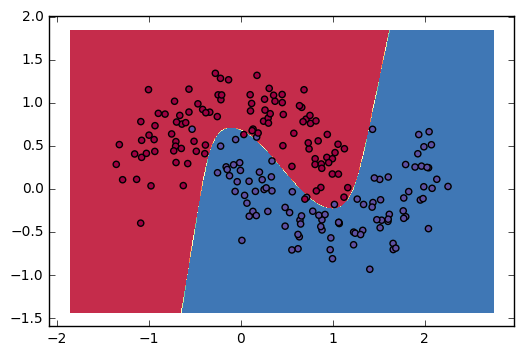

In [18]:
three_layer_neural_network_SL.main('tanh')